In [2]:
## import libraries

import sys
import os
from anlffr.helper import biosemi2mne as bs
from anlffr.preproc import find_blinks
from mne import compute_proj_epochs
import numpy as np
import mne
from scipy.io import savemat
import fnmatch
from mne.datasets import fetch_fsaverage

In [3]:
## setting src and bem from template 

fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)
subject = "fsaverage"
trans = "fsaverage"  # MNE has a built-in fsaverage transformation
src = os.path.join(fs_dir, "bem", "fsaverage-ico-5-src.fif")
bem = os.path.join(fs_dir, "bem", "fsaverage-5120-5120-5120-bem-sol.fif")
montage = mne.channels.make_standard_montage("biosemi32")

0 files missing from root.txt in C:\Users\amukesh\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage


In [27]:
## for loop starts for each data set

fl1='//datadepot.rcac.purdue.edu/depot/heinz/data/UserTESTS/AM/bdf data/human_GDT/'
os.chdir(fl1)
fln=os.listdir()
fln=fln[30:]
for file in fln:
    if file.startswith("S"):
        ## loading bds files in seqne ce and concatenating
        os.chdir(file)
        bdfs = fnmatch.filter(os.listdir(),'*.bdf')
        ss=[sum([ord(char) for char in string]) for string in bdfs]
        kp=(np.argsort(ss)).tolist()
        bdfs=[bdfs[ii] for ii in kp]
        rawlist=[]
        eveslist=[]
        for rawname in bdfs:
            rawtemp,evestemp = bs.importbdf(rawname, verbose='DEBUG',refchans=['EXG1', 'EXG2'])
            rawlist += [rawtemp, ]
            eveslist += [evestemp, ]
        raw, eves = mne.concatenate_raws(rawlist, events_list=eveslist)

        raw.filter(1.,40.)
        
        ## blink rejection
        blinks = find_blinks(raw)
        epochs_blinks = mne.Epochs(raw, blinks, event_id=998, baseline=(-0.25, 0.25),reject=dict(eeg=500e-6), tmin=-0.25, tmax=0.25)
        blink_proj = compute_proj_epochs(epochs_blinks, n_eeg=1)
        raw.add_proj(blink_proj)
        
        
        ## rename channel names in raw with those in montage.
        raw.set_eeg_reference(projection=True)
        mdc = dict(zip(raw.ch_names,montage.ch_names))
        raw.rename_channels(mdc)
        raw.set_montage(montage,on_missing='ignore')
        raw.pick_channels(montage.ch_names)
 

        ## making forward solution
        fwd = mne.make_forward_solution(
            raw.info,
            trans=trans,
            src=src,
            bem=bem,
            eeg=True,
            mindist=5.0,
            n_jobs=None,
        )

        for kk in range(3):
            epoch=mne.Epochs(raw, eves, event_id=kk+1, baseline=(-0.3, 0), proj=True,tmin=-0.3, tmax=2.2, reject=dict(eeg=150e-6),preload=True)
            
            if len(epoch)<3:
                continue

            
            evoked=epoch.average()


            

            noise_cov = mne.compute_covariance(
                epoch, tmax=0.0, method=["shrunk", "empirical"], rank=None, verbose=True)
            
            inverse_operator = mne.minimum_norm.make_inverse_operator(
                evoked.info, fwd, noise_cov, loose=0.2, depth=0.8)
            
            method = "dSPM"
            snr = 3.0
            lambda2 = 1.0 / snr**2
            stc, residual = mne.minimum_norm.apply_inverse(
                evoked,
                inverse_operator,
                lambda2,
                method=method,
                pick_ori=None,
                return_residual=True,
                verbose=True)
            stc_str=file+'_'+str(kk+1)+'.stc'
            stc.save(stc_str, overwrite=True)




    os.chdir(fl1)


    





Loading a default 32 channel montage.
Extracting EDF parameters from \\datadepot.rcac.purdue.edu\depot\heinz\data\UserTESTS\AM\bdf data\human_GDT\S339\S339_GDT.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8622079  =      0.000 ...  2105.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of 131071 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
751 events found on stim channel Status
Event IDs: [  1   2   3 253]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband e

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.3s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 90113 samples (22.000 s)

Not setting metadata
115 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
    Rejecting  epoch based on EEG : ['A5', 'A9', 'A13', 'A22', 'A32']
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=89.9%)
1 projection items deactivated
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


Source space          : C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif
MRI -> head transform : c:\Users\amukesh\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\data\fsaverage\fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999994 0.003552 0.000202      -1.76 mm
    -0.003558 0.998389 0.056626      31.09 mm
    -0.000001 -0.056626 0.998395      39.60 mm
    0.000000 0.000000 0.000000       1.00

Read  32 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.0s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 90113 samples (22.000 s)

Not setting metadata
113 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
    Rejecting  epoch based on EEG : ['A30']
    Rejecting  epoch based on EEG : ['A30']
    Rejecting  epoch based on EEG : ['A30']
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=71.5%)
1 projection items deactivated
EEG channel type selected for re-referencing
Adding average EEG

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


Source space          : C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif
MRI -> head transform : c:\Users\amukesh\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\data\fsaverage\fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999994 0.003552 0.000202      -1.76 mm
    -0.003558 0.998389 0.056626      31.09 mm
    -0.000001 -0.056626 0.998395      39.60 mm
    0.000000 0.000000 0.000000       1.00

Read  32 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.1s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 90113 samples (22.000 s)

Not setting metadata
388 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s


No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=85.6%)
1 projection items deactivated
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Source space          : C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif
MRI -> head transform : c:\Users\amukesh\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\data\fsaverage\fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading C:\Users\amukesh\mne_data\MNE

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.1s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 90113 samples (22.000 s)

Not setting metadata
1683 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
    Rejecting  epoch based on EEG : ['A6']
    Rejecting  epoch based on EEG : ['A17']


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s


    Rejecting  epoch based on EEG : ['A29']
    Rejecting  epoch based on EEG : ['A29']
    Rejecting  epoch based on EEG : ['A29']
    Rejecting  epoch based on EEG : ['A29']
    Rejecting  epoch based on EEG : ['A29']


[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.4s


    Rejecting  epoch based on EEG : ['A6']


[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.7s


    Rejecting  epoch based on EEG : ['A29']
    Rejecting  epoch based on EEG : ['A29']
    Rejecting  epoch based on EEG : ['A29']
    Rejecting  epoch based on EEG : ['A29']
    Rejecting  epoch based on EEG : ['A29']
    Rejecting  epoch based on EEG : ['A29']
    Rejecting  epoch based on EEG : ['A29']
    Rejecting  epoch based on EEG : ['A29']
    Rejecting  epoch based on EEG : ['A29']
    Rejecting  epoch based on EEG : ['A29']
    Rejecting  epoch based on EEG : ['A29']
    Rejecting  epoch based on EEG : ['A29']
    Rejecting  epoch based on EEG : ['A29']
    Rejecting  epoch based on EEG : ['A29']
    Rejecting  epoch based on EEG : ['A29']
    Rejecting  epoch based on EEG : ['A29']
    Rejecting  epoch based on EEG : ['A29']
    Rejecting  epoch based on EEG : ['A29']
    Rejecting  epoch based on EEG : ['A29']


[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.9s


No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=79.7%)
1 projection items deactivated
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Source space          : C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif
MRI -> head transform : c:\Users\amukesh\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\data\fsaverage\fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading C:\Users\amukesh\mne_data\MNE

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.0s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 90113 samples (22.000 s)

Not setting metadata
329 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
    Rejecting  epoch based on EEG : ['A10']
No channels 'grad' found. Skipping.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s


No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=80.6%)
1 projection items deactivated
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Source space          : C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif
MRI -> head transform : c:\Users\amukesh\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\data\fsaverage\fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaver

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.3s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 90113 samples (22.000 s)

Not setting metadata
1047 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecti

[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.3s


    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecti

[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.5s


    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3']
    Rejecting  epoch based on EEG : ['A3', 'A6']
    Rejecting  epoch based on EEG : ['A3']
    R

[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.9s


Source space          : C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif
MRI -> head transform : c:\Users\amukesh\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\data\fsaverage\fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999994 0.003552 0.000202      -1.76 mm
    -0.003558 0.998389 0.056626      31.09 mm
    -0.000001 -0.056626 0.998395      39.60 mm
    0.000000 0.000000 0.000000       1.00

Read  32 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.


C:\Users\amukesh\AppData\Local\Temp\2\ipykernel_20744\2176853718.py:52: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epoch=mne.Epochs(raw, eves, event_id=kk+1, baseline=(-0.3, 0), proj=True,tmin=-0.3, tmax=2.2, reject=dict(eeg=150e-6),preload=True)


    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7', 'FC5']
    Rejecting  epoch based on EEG : ['F7', 'FC5']
    Rejecting  epoch based on EEG : ['F7', 'Fp2']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'PO4']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7', 'FC5']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz']
    Rejecting  epoch based on EEG : ['F7', 'FC5']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.2s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 90113 samples (22.000 s)

Not setting metadata
183 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=90.8%)
1 projection items deactivated
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


Source space          : C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif
MRI -> head transform : c:\Users\amukesh\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\data\fsaverage\fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999994 0.003552 0.000202      -1.76 mm
    -0.003558 0.998389 0.056626      31.09 mm
    -0.000001 -0.056626 0.998395      39.60 mm
    0.000000 0.000000 0.000000       1.00

Read  32 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.3s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 90113 samples (22.000 s)

Not setting metadata
534 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


    Rejecting  epoch based on EEG : ['A1']
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=90.3%)
1 projection items deactivated
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s


Source space          : C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif
MRI -> head transform : c:\Users\amukesh\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\data\fsaverage\fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999994 0.003552 0.000202      -1.76 mm
    -0.003558 0.998389 0.056626      31.09 mm
    -0.000001 -0.056626 0.998395      39.60 mm
    0.000000 0.000000 0.000000       1.00

Read  32 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.3s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 90113 samples (22.000 s)

Not setting metadata
751 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.3s


No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=85.0%)
1 projection items deactivated
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Source space          : C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif
MRI -> head transform : c:\Users\amukesh\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\data\fsaverage\fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading C:\Users\amukesh\mne_data\MNE

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.4s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 90113 samples (22.000 s)

Not setting metadata
335 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s


No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=92.2%)
1 projection items deactivated
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Source space          : C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif
MRI -> head transform : c:\Users\amukesh\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\data\fsaverage\fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : C:\Users\amukesh\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading C:\Users\amukesh\mne_data\MNE

In [38]:
t=epoch.times
pre1=np.intersect1d(np.where(t>0.3), np.where(t<=0.5))
pos1=np.intersect1d(np.where(t>0.5), np.where(t<=0.8))

In [41]:
sdata=stc.data
pr1=sdata[:,pre1]
po1=sdata[:,pos1]
id1=(np.sqrt(np.mean(po1**2,axis=1))-np.sqrt(np.mean(pr1**2,axis=1)))/np.sqrt(np.mean(pr1**2,axis=1))

In [59]:
stc1=stc
stc1.data=(np.tile(id1,(10,1))).transpose()
vmin=min(id1)
vmax=max(id1)
vmid=np.mean(id1)

In [58]:
vmid

np.float64(0.01153783509142964)

In [60]:
vertno_max, time_max = stc1.get_peak(hemi="rh")
surfer_kwargs = dict(
    hemi="both",
    subjects_dir=subjects_dir,
    clim=dict(kind="value", lims=[vmin, vmid, vmax]),
    views="lateral",
    initial_time=time_max,
    time_unit="s",
    size=(800, 800),
    smoothing_steps=10,
)


Using control points [0.86140632 0.96912439 1.80546788]
False


C:\Users\amukesh\AppData\Roaming\Python\Python310\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(HTML).__init__(disabled=True).
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(
C:\Users\amukesh\AppData\Roaming\Python\Python310\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(
C:\Users\amukesh\AppData\Roaming\Python\Python310\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(HTML).__init__(disabled=True).
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecate

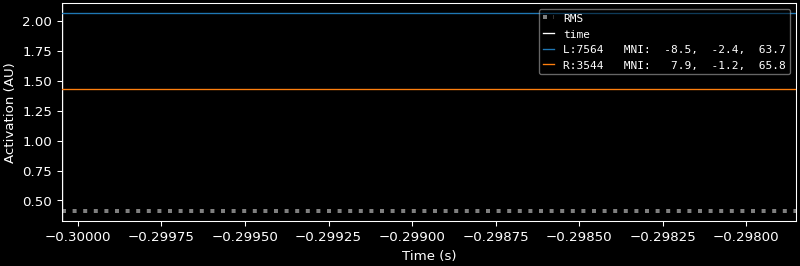

In [64]:
brain = stc1.plot(hemi="both")

False


C:\Users\amukesh\AppData\Roaming\Python\Python310\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(HTML).__init__(disabled=True).
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(
C:\Users\amukesh\AppData\Roaming\Python\Python310\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(
C:\Users\amukesh\AppData\Roaming\Python\Python310\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(HTML).__init__(disabled=True).
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecate

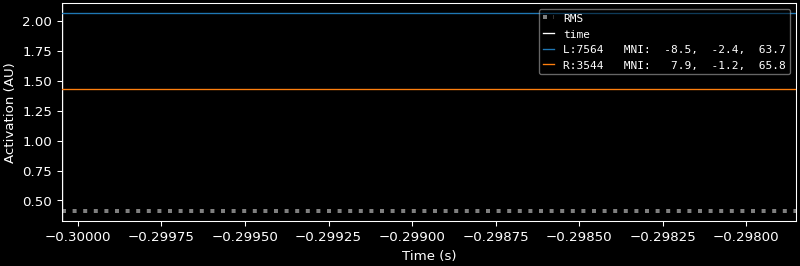

In [65]:
brain=stc.plot(**surfer_kwargs)

In [86]:
20480/8


2560.0

In [72]:
x=stc.data

In [73]:
print(np.shape(x))

(20484, 10)


In [74]:
print(x[:10])

[[-0.57597192 -0.57597192 -0.57597192 -0.57597192 -0.57597192 -0.57597192
  -0.57597192 -0.57597192 -0.57597192 -0.57597192]
 [-0.31246288 -0.31246288 -0.31246288 -0.31246288 -0.31246288 -0.31246288
  -0.31246288 -0.31246288 -0.31246288 -0.31246288]
 [ 0.15873075  0.15873075  0.15873075  0.15873075  0.15873075  0.15873075
   0.15873075  0.15873075  0.15873075  0.15873075]
 [-0.15776341 -0.15776341 -0.15776341 -0.15776341 -0.15776341 -0.15776341
  -0.15776341 -0.15776341 -0.15776341 -0.15776341]
 [-0.37419855 -0.37419855 -0.37419855 -0.37419855 -0.37419855 -0.37419855
  -0.37419855 -0.37419855 -0.37419855 -0.37419855]
 [-0.4289189  -0.4289189  -0.4289189  -0.4289189  -0.4289189  -0.4289189
  -0.4289189  -0.4289189  -0.4289189  -0.4289189 ]
 [ 0.6893657   0.6893657   0.6893657   0.6893657   0.6893657   0.6893657
   0.6893657   0.6893657   0.6893657   0.6893657 ]
 [ 0.29085032  0.29085032  0.29085032  0.29085032  0.29085032  0.29085032
   0.29085032  0.29085032  0.29085032  0.29085032]
 [